# BEE 4750 Homework 2: Dissolved Oxygen

**Name**: Caleb Julian-Kwong

**ID**: cmj66

> **Due Date**
>
> Friday, 09/22/23, 9:00pm

## Overview

### Instructions

This assignment asks you to use a simulation model for dissolved oxygen
to assess the impacts of two wastewater streams, including minimum
treatment levels and the impact of uncertain environmental conditions.
You will also be asked to identify a minimum distance for the addition
of a third discharge stream.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [21]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Desktop/BEE 4750/hw02-cmj66`


In [22]:
using Plots
using LaTeXStrings
using Distributions

## Problems (Total: 40 Points)

A river which flows at 6 km/d is receiving waste discharges from two
sources which are 15 km apart, as shown in
<a href="#fig-river" class="quarto-xref">Figure 1</a>. The oxygen
reaeration rate is 0.55 day<sup>-1</sup>, and the decay rates of CBOD
and NBOD are are 0.55 and 0.25 day<sup>-1</sup>, respectively. The
river’s saturated dissolved oxygen concentration is 10m g/L.

![Figure 1: Schematic of the
system](attachment:figures/river_diagram.png)

### Problem 1 (8 points)

If the characteristics of the river inflow and waste discharges are
given in <a href="#tbl-river" class="quarto-xref">Table 1</a>, write a
Julia model to compute the dissolved oxygen concentration from the first
wastewater discharge to an arbitrary distance `d` km downstream. Use
your model to compute the maximum dissolved oxygen concentration up to
50km downstream and how far downriver this maximum occurs.

|    Parameter     |            River Inflow |         Waste Stream 1 |         Waste Stream 2 |
|:----------------:|------------------------:|-----------------------:|-----------------------:|
|      Inflow      | 100,000 m<sup>3</sup>/d | 10,000 m<sup>3</sup>/d | 15,000 m<sup>3</sup>/d |
| DO Concentration |                7.5 mg/L |                 5 mg/L |                 5 mg/L |
|       CBOD       |                  5 mg/L |                50 mg/L |                45 mg/L |
|       NBOD       |                  5 mg/L |                35 mg/L |                35 mg/L |

Table 1: River inflow and waste stream characteristics for Problem 1.

In [23]:
#concentrations in units of mg/L
#=river_do = 7.5
river_CBOD = 5
river_NBOD = 5
waste1_do = 5
waste1_CBOD = 50
waste1_NBOD = 35
waste2_do = 5
waste2_CBOD = 45
waste2_NBOD = 35

#flow rates in units of L/d
q_river = 100000
q_stream1 = 10000
q_stream2 = 15000
q_entry1 = q_river + q_stream1
q_entry2 = q_entry1 + q_stream2
=#


function dissolved_oxygen(x, river_do, river_CBOD, river_NBOD, q_river, waste1_do, waste1_CBOD, waste1_NBOD,q_stream1,
    waste2_do, waste2_CBOD, waste2_NBOD, q_stream2, stream2_distance)
    #x is how far downstream you want to measure dissolved oxygen
    #stream2_distance is the distance downstream to stream 2
    #rates used for later calculations
    ka = 0.55
    kc = 0.35
    kn = 0.25
    max_do = 10

    #flow rates in units of L/d
    q_entry1 = q_river + q_stream1
    q_entry2 = q_entry1 + q_stream2

    #velcity of river in units of km/d
    velocity = 6

    #concentrations at waste source 1
    do_concentration1 = ((q_river * river_do) + (q_stream1 * waste1_do)) / (q_entry1)
    cbod_concentration1 = ((q_river * river_CBOD) + (q_stream1 * waste1_CBOD)) / (q_entry1)
    nbod_concentration1 = ((q_river * river_NBOD) + (q_stream1 * waste1_NBOD)) / (q_entry1)

    #ignoring photosynthesis, respiration, and benthal uptake
    #if you want the dissolved oxygen before stream 2
    if x <= 15
        #calculating alpha values
        alpha1 = exp(-ka * x / velocity)
        alpha2 = (kc / (ka - kc)) * (exp(-kc * x / velocity) - alpha1)
        alpha3 = (kn / (ka - kn)) * (exp(-kn * x / velocity) - alpha1)

        #dissolved oxygen concentration x km downstream
        dissolved_oxygen_concentration = (max_do * (1 - alpha1)) + (do_concentration1 * alpha1) - (cbod_concentration1 * alpha2) - (nbod_concentration1 * alpha3)
        return dissolved_oxygen_concentration
    #if you want the dissolved oxygen after stream 2
    else
        #calculating dissolved oxygen concentration just before stream 2
        alpha1 = exp(-ka * stream2_distance / velocity)
        alpha2 = (kc / (ka - kc)) * (exp(-kc * stream2_distance / velocity) - alpha1)
        alpha3 = (kn / (ka - kn)) * (exp(-kn * stream2_distance / velocity) - alpha1)
        do_concentration_before2 = (max_do * (1 - alpha1)) + (do_concentration1 * alpha1) - (cbod_concentration1 * alpha2) - (nbod_concentration1 * alpha3)
        #calculating CBOD and NBOD concentration just before stream 2
        cbod_concentration_before2 = cbod_concentration1 * exp(-kc * stream2_distance / velocity)
        nbod_concentration_before2 = nbod_concentration1 * exp(-kn * stream2_distance / velocity)

        #concentrations at waste source 2
        do_concentration2 = ((q_entry1 * do_concentration_before2) + (q_stream2 * waste2_do)) / (q_entry2)
        cbod_concentration2 = ((q_entry1 * cbod_concentration_before2) + (q_stream2 * waste2_CBOD)) / (q_entry2)
        nbod_concentration2 = ((q_entry1 * nbod_concentration_before2) + (q_stream2 * waste2_NBOD)) / (q_entry2)

        #calculating alpha values
        alpha1 = exp(-ka * (x - stream2_distance) / velocity)
        alpha2 = (kc / (ka - kc)) * (exp(-kc * (x - stream2_distance) / velocity) - alpha1)
        alpha3 = (kn / (ka - kn)) * (exp(-kn * (x - stream2_distance) / velocity) - alpha1)

        #dissolved oxygen concentration x km downstream
        dissolved_oxygen_concentration = (max_do * (1 - alpha1)) + (do_concentration2 * alpha1) - (cbod_concentration2 * alpha2) - (nbod_concentration2 * alpha3)
        return dissolved_oxygen_concentration
    end
end



#Finding the maximum dissolved oxygen from 0 to 50 km downstream
max_do = 0
max_distance = 0
for d in 0:0.1:50
    oxygen = dissolved_oxygen(d, 7.5, 5, 5, 100000, 5, 50, 35, 10000, 5, 45, 35, 15000, 15)
    #println(string(oxygen) * " at " * string(d))
    if oxygen > max_do
        max_do = oxygen
        max_distance = d
    end
end
println("Maximum dissolved oxygen levels are " * string(max_do) * " mg/L which occur " * string(max_distance) * " km downstream")



#Finding the minimum dissolved oxygen from 0 to 50 km downstream
min_distance = 0
min_do = dissolved_oxygen(0, 7.5, 5, 5, 100000, 5, 50, 35, 10000, 5, 45, 35, 15000, 15)
for d in 0:0.1:50
    oxygen = dissolved_oxygen(d, 7.5, 5, 5, 100000, 5, 50, 35, 10000, 5, 45, 35, 15000, 15)
    #println(string(oxygen) * " at " * string(d))
    if oxygen < min_do
        min_do = oxygen
        min_distance = d
    end
end
println("Minimum dissolved oxygen levels are " * string(min_do) * " mg/L which occur " * string(min_distance) * " km downstream")



Maximum dissolved oxygen levels are 7.2727272727272725 mg/L which occur 0.0 km downstream
Minimum dissolved oxygen levels are 3.755700469829069 mg/L which occur 22.3 km downstream


### Problem 2 (4 points)

Use your model to plot the dissolved oxygen concentration in the river
from the first waste stream to 50km downstream. What do you notice?

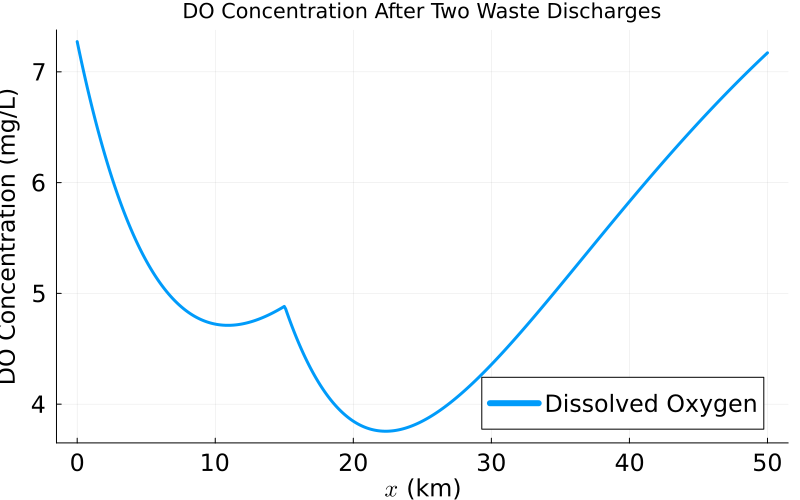

In [24]:
#Calculating values of dissolved oxygen from 0 to 50 km downstream
x = 0:0.1:50
C = (y -> dissolved_oxygen(y, 7.5, 5, 5, 100000, 5, 50, 35, 10000, 5, 45, 35, 15000, 15)).(x)
#print(C)
plot(x, C; linewidth=3, 
    label="Dissolved Oxygen", 
    tickfontsize=16, 
    guidefontsize=16, 
    legendfontsize=16)
xlabel!(L"$x$ (km)")
ylabel!("DO Concentration (mg/L)")
title!("DO Concentration After Two Waste Discharges")
plot!(size=(800, 500))

You can see how dissolved oxygen concentrations decrease after each discharge of NBOD and CBOD into the river. You can also see that DO reaches its lowest concentration (of 3.76 mg/L) at 22.3 km downstream. Interestingly, DO actually begins to increase just before the second discharge. Lastly, you can see that DO recovers to its normal levels at around 50km downstream.

### Problem 3 (3 points)

Under the assumptions of Problem 1, determine the distance from waste
stream 2 it will take for the dissolved oxygen concentration of the
river to recover to 6 mg/L.

In [25]:
recovery_level = 6
#finds the distance downstream for the stream dissolved oxygen to recover to a certain level
function recovery_distance(reovery_level)
    for i in 1:length(C) - 1
        #checking to see if dissolved oxygen is below recovery_level at position i and above recovery_level at position i + 1
        if C[i] < recovery_level && C[i + 1] > recovery_level
            return i + 1
        end
    end
end

#divide by 10 because C goes through 0.1 km at a time
recovery_dist = (recovery_distance(recovery_level) / 10) - 15

println("DO levels will recover to 6 mg/L at " * string(recovery_dist) * " km downstream")

DO levels will recover to 6 mg/L at 26.299999999999997 km downstream


### Problem 4 (5 points)

What is the minimum level of treatment (% removal of organic waste) for
waste stream 2 that will ensure that the dissolved oxygen concentration
never drops below 4 mg/L, assuming that waste stream 1 remains
untreated?

In [26]:

function min_oxygen(x, river_do, river_CBOD, river_NBOD, q_river, waste1_do, waste1_CBOD, waste1_NBOD, q_stream1, waste2_do,
        waste2_CBOD, waste2_NBOD, q_stream2, stream2_distance)
    #function finds the lowest dissolved oxygen levels from 0 to x km downstream
    #least_oxygen represents the lowest dissolved oxygen levels for that % removal of organic waste
    least_oxygen = dissolved_oxygen(0, river_do, river_CBOD, river_NBOD, q_river, waste1_do, waste1_CBOD, waste1_NBOD, q_stream1, 
        waste2_do, waste2_CBOD, waste2_NBOD, q_stream2, stream2_distance)
    #finding the dissolved oxygen levels at each km up to x km downstream
    for d in 1:0.1:x
        oxygen = dissolved_oxygen(d, river_do, river_CBOD, river_NBOD, q_river, waste1_do, waste1_CBOD, waste1_NBOD, q_stream1,
            waste2_do, waste2_CBOD, waste2_NBOD, q_stream2, stream2_distance)
        if (oxygen < least_oxygen)
            least_oxygen = oxygen
        end
    end
    return least_oxygen
end
#min_oxygen(50, 7.5, 5, 5, 100000, 5, 50, 35, 10000, 5, 45, 35, 15000, 15)


min_oxygen (generic function with 1 method)

In [27]:
percent_removal = 0
#max_least_oxygen is the highest dissolved oxygen level out of all the minimum dissolved oyxgen levels from each % removal of organic waste simulation
max_least_oxygen = 0

#while loop will run until the lowest dissolved oxygen level is above 4 mg/L
while max_least_oxygen <= 4
    percent_removal = percent_removal + 0.01
    #adjusting for % removal of organic waste
    waste2_CBOD = 45 * (1 - percent_removal)
    waste2_NBOD = 35 * (1 - percent_removal)
    #least_oxygen represents the lowest dissolved oxygen levels for that % removal of organic waste
    least_oxygen = min_oxygen(50, 7.5, 5, 5, 100000, 5, 50, 35, 10000, 5, waste2_CBOD, waste2_NBOD, 15000, 15)
    #println(least_oxygen)
    #adjusting max_least_oxygen level if it is lower than least_oxygen
    if max_least_oxygen < least_oxygen
        max_least_oxygen = least_oxygen
    end
end
#println(max_least_oxygen)
println("The DO concentration won't drop below 4 mg/L if we remove " * string(percent_removal * 100) * " % of organic waste from stream 2")

The DO concentration won't drop below 4 mg/L if we remove 11.999999999999998 % of organic waste from stream 2


### Problem 5 (5 points)

If both waste streams are treated equally, what is the minimum level of
treatment (% removal of organic waste) for the two sources required to
ensure that the dissolved oxygen concentration never drops below 4 mg/L?

In [28]:
percent_removal = 0
#max_least_oxygen is the highest dissolved oxygen level out of all the minimum dissolved oyxgen levels from each % removal of organic waste simulation
max_least_oxygen = 0

#while loop will run until the lowest dissolved oxygen level is above 4 mg/L
while max_least_oxygen < 4
    #adjusting for % removal of organic waste
    waste1_CBOD = 50 * (1 - percent_removal)
    waste1_NBOD = 35 * (1 - percent_removal)
    waste2_CBOD = 45 * (1 - percent_removal)
    waste2_NBOD = 35 * (1 - percent_removal)
    #least_oxygen represents the lowest dissolved oxygen levels for that % removal of organic waste
    least_oxygen = min_oxygen(50, 7.5, 5, 5, 100000, 5, waste1_CBOD, waste1_NBOD, 10000, 5, waste2_CBOD, waste2_NBOD, 15000, 15)
    #adjusting max_least_oxygen level if it is lower than least_oxygen
    if max_least_oxygen < least_oxygen
        max_least_oxygen = least_oxygen
    end
    percent_removal = percent_removal + 0.001
end
#println(max_least_oxygen)
println("The DO concentration won't drop below 4 mg/L if we remove " * string(percent_removal * 100) * " % of organic waste from both streams")


The DO concentration won't drop below 4 mg/L if we remove 6.700000000000005 % of organic waste from both streams


### Problem 6 (5 points)

Suppose you are responsible for designing a waste treatment plan for
discharges into the river, with a regulatory mandate to keep the
dissolved oxygen concentration above 4 mg/L. Discuss whether you’d opt
to treat waste stream 2 alone or both waste streams equally. What other
information might you need to make a conclusion, if any?

Assuming it costs the same to remove organic waste from each stream, we should choose the treatment plan with the least cost (and therefore the least removal of organic waste). If we only remove waste from stream 2, we have to remove 12% of the total waste (or 144 grams of waste per day). If we remove 6.7% of the total waste from streams 1 and 2, we have to remove a total of 137.35 grams of waste per day. Therefore, we should remove waste from both stream 1 and 2 since it will require less removal of waste and will be cheaper. However, our answer assumes that the cost per gram of removing waste is the same in stream 1 and 2. If the cost structure of waste removal between streams were different, our answer could change. Another consideration that could change our decision could include who is paying for waste removal; if the government is paying for waste removal, it should pick whatever option is cheaper. If companies are responsible for waste removal, then they should both share the cost since they are both polluting.

### Problem 7 (5 points)

Suppose that it is known that the DO concentrations at the river inflow
can vary uniformly between 6 mg/L and 8 mg/L. How often will the
treatment plan identified in Problem 5 (both waste streams treated
equally) fail to comply with the regulatory standard?

In [29]:
#treatment plan from problem 5 removes 7% of organic waste from stream 1 and 2
#adjusting for % removal of organic waste
waste1_CBOD = 50 * 0.93
waste1_NBOD = 35 * 0.93
waste2_CBOD = 45 * 0.93
waste2_NBOD = 35 * 0.93

#failure is the number of times the treatment plan fails with the regulatory standard
failure = 0
trials = 10000

for i in 1:trials
    #don't need to use a random number generator since do concentration probability distribution is uniform
    river_do = 6 + (8-6) * (i / trials)
    #least_oxygen represents the lowest dissolved oxygen levels for 8% removal of organic waste
    least_oxygen = min_oxygen(50, river_do, 5, 5, 100000, 5, waste1_CBOD, waste1_NBOD, 10000, 5, waste2_CBOD, waste2_NBOD, 15000, 15)
    if least_oxygen < 4
        failure = failure + 1
    end
end

failure_rate = failure * 100 / trials
println("The treatment plan from Problem 5 fails " * string(failure_rate) * "% of the time")


The treatment plan from Problem 5 fails 66.93% of the time


### Problem 8 (5 points)

A factory is planning a third wastewater discharge into the river
downstream of the second plant. This discharge would consist of 5
m<sup>3</sup>/day of wastewater with a dissolved oxygen content of 4.5
mg/L and CBOD and NBOD levels of 50 and 45 mg/L, respectively.

Assume that the treatment plan you identified in Problem 5 is still in
place for the existing discharges. If the third discharge will not be
treated, under the original inflow conditions (7.5 mg/L DO), how far
downstream from the second discharge does this third discharge need to
be placed to keep the river concentration from dropping below 4 mg/L?

In [30]:
#flow rates in units of L/d
q_river = 100000
q_stream1 = 10000
q_stream2 = 15000
q_stream3 = 5000
q_entry1 = q_river + q_stream1
q_entry2 = q_entry1 + q_stream2

#concentrations in units of mg/L
#adjusting for % removal of organic waste
river_do = 7.5
river_CBOD = 5
river_NBOD = 5
waste1_do = 5
waste1_CBOD = 50 * 0.933
waste1_NBOD = 35 * 0.933
waste2_do = 5
waste2_CBOD = 45 * 0.933
waste2_NBOD = 35 * 0.933
waste3_do = 4.5
waste3_CBOD = 50
waste3_NBOD = 45

#ates used later calculations
ka = 0.55
kc = 0.35
kn = 0.25
max_do = 10

#velcity of river in units of km/d
velocity = 6

#calculating alpha values
alpha1 = exp(-ka * 15 / velocity)
alpha2 = (kc / (ka - kc)) * (exp(-kc * 15 / velocity) - alpha1)
alpha3 = (kn / (ka - kn)) * (exp(-kn * 15 / velocity) - alpha1)

#concentrations at waste source 1
do_concentration1 = ((q_river * river_do) + (q_stream1 * waste1_do)) / (q_entry1)
cbod_concentration1 = ((q_river * river_CBOD) + (q_stream1 * waste1_CBOD)) / (q_entry1)
nbod_concentration1 = ((q_river * river_NBOD) + (q_stream1 * waste1_NBOD)) / (q_entry1)

#calculating DO, CBOD and NBOD concentration just before stream 2
do_concentration_before2 = (max_do * (1 - alpha1)) + (do_concentration1 * alpha1) - (cbod_concentration1 * alpha2) - (nbod_concentration1 * alpha3)
cbod_concentration_before2 = cbod_concentration1 * exp(-kc * 15 / velocity)
nbod_concentration_before2 = nbod_concentration1 * exp(-kn * 15 / velocity)

#concentrations at waste source 2
do_concentration2 = ((q_entry1 * do_concentration_before2) + (q_stream2 * waste2_do)) / (q_entry2)
cbod_concentration2 = ((q_entry1 * cbod_concentration_before2) + (q_stream2 * waste2_CBOD)) / (q_entry2)
nbod_concentration2 = ((q_entry1 * nbod_concentration_before2) + (q_stream2 * waste2_NBOD)) / (q_entry2)

#distance is how far downstream stream 3 is from stream 2
distance = 0

#max_least_oxygen is the highest dissolved oxygen level out of all the minimum dissolved oyxgen levels for stream 3 being a certain distance downstream of stream 2
max_least_oxygen = 0

#while loop will run until the lowest dissolved oxygen level is above 4 mg/L
while max_least_oxygen < 4
    #least_oxygen represents the lowest dissolved oxygen levels for that distance downstream from the second inflow
    least_oxygen = min_oxygen(50, do_concentration2, cbod_concentration2, nbod_concentration2, q_entry2, 0, 0, 0, 0, waste3_do, waste3_CBOD, waste3_NBOD, q_stream3, distance)
    #adjusting max_least_oxygen level if it is lower than least_oxygen
    if max_least_oxygen < least_oxygen
        max_least_oxygen = least_oxygen
    end
    #adjusting for distance downstream from stream 2
    distance = distance+ 0.1
end

print("Stream 3 needs to be " * string(distance) * " km downstream from stream 2 to keep the river concentration of dissolved oxygen from dropping below 4 mg/L")



Stream 3 needs to be 9.399999999999983 km downstream from stream 2 to keep the river concentration of dissolved oxygen from dropping below 4 mg/L

## References

List any external references consulted, including classmates.

I used https://www.machinelearningplus.com/julia/while-loop-in-julia/ to understand the format of while loops. However, I did not copy any code.

I worked on questions 1 through 6 with Abigail Perree. I also worked on the entirety of this lab with Maya Yu and Kiley Espineira.